# Aula 3 - Métodos ensemble
### Bagging vs Boosting

Pra lembrar as principais diferenças entre os dois métodos de ensemble que estudamos:

<img src=https://pluralsight2.imgix.net/guides/81232a78-2e99-4ccc-ba8e-8cd873625fdf_2.jpg width=600>

## Gradient boosting

Além dos métodos que estudamos, há ainda outras classes de métodos de ensemble!

Em particular, a classe de modelos que se utilizam do procedimento de **gradient boosting**.

O gradient boosting também é baseado no princípio de boosting (utilização de weak learners sequencialmente adicionados de modo a **sequencialmente minimizar os erros cometidos**).

<img src=https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png width=600>

Mas este método implementa o boosting através de um **gradiente** explícito.

A ideia é que caminhemos na direção do **erro mínimo** de maneira iterativa **passo a passo**.

Este caminho se dá justamente pelo **gradiente** da **função de custo/perda**, que mede justamente os erros cometidos.

<img src=https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif width=400>

Este método é conhecido como:

### Gradiente descendente


Deixei em ênfase porque este será um método de **enorme importância** no estudo de redes neurais (e é, em geral, um método de otimização muito utilizado).

O objetivo geral do método é bem simples: determinar quais são os **parâmetros** da hipótese que minimizam a função de custo/perda. Para isso, o método "percorre" a função de erro, indo em direção ao seu mínimo (e este "caminho" feito na função se dá justamente pela **determinação iterativa dos parâmetros**, isto é, **a cada passo, chegamos mais perto dos parâmetros finais da hipótese**, conforme eles são ajustados aos dados.

> **Pequeno interlúdio matemático:** o gradiente descendente implementado pelo gradient boosting é, na verdade, um **gradiente descendente funcional**, isto é, desejamos encontrar não um conjunto de parâmetros que minimiza o erro, mas sim **introduzir sequencialmente weak learners (hipótese simples) que minimizam o erro**. Desta forma, o gradient boosting minimiza a função de custo ao ecolher iterativamente hipóteses simples que apontam na direção do mínimo, neste espaço funcional.

Apesar do interlúdio acima, não precisamos nos preocupar muito com os detalhes matemáticos: o que importa é entender que no caso do gradient boosting, há alguns pontos importantes:

- Uma **função de custo/perda (loss)** é explicitamente minimizada por um procedimento de gradiente;

- O gradiente está relacionado com o procedimento de **encadeamento progressivo entre weak learners**, seguindo a ideia do boosting.

Pra quem quiser saber um pouco mais de detalhes (e se aventurar na matemática), sugiro [este post](https://www.gormanalysis.com/blog/gradient-boosting-explained/) ou então [este site](https://explained.ai/gradient-boosting/), que contém vários materiais ótimos para entender o método com todos os detalhes matemáticos.

Os [vídeos do StatQuest](https://www.youtube.com/playlist?list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6) também são uma boa referência!



As classes do sklearn são:

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

E os principais hiperparâmetros a serem ajustados são:

- `n_estimators` : novamente, o número de weak learners encadeados.

- `learning_rate` : a constante que multiplica o gradiente no gradiente descendente. Essencialmente, controla o "tamanho do passo" a ser dado em direção ao mínimo.

Segundo o próprio [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting): "*Empirical evidence suggests that small values of `learning_rate` favor better test error. The lireature recommends to set the learning rate to a small constant (e.g. `learning_rate <= 0.1`) and choose `n_estimators` by early stopping.*"

Ainda sobre a learning rate, as ilustrações a seguir ajudam a entender sua importância:

<img src=https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png width=700>

<img src=https://cdn-images-1.medium.com/max/1440/0*A351v9EkS6Ps2zIg.gif width=500>

Vamos treinar nosso classificador baseline de gradient boosting:

In [1]:
# importar as bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import GradientBoostingClassifier

In [5]:
# copiando o pipeline da aula anterior
def pipe_pre_process_german(df, X, y):
    # Particiona os dados a fim de poder avaliar o modelo ao fim do processo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # EDA -> Preprocessamento de dados
    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                                  ("min_max", MinMaxScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                  ("onehot", OneHotEncoder())])

    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, y_train, X_test, y_test, pre_processador

In [6]:
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

# Definir quem são as variáveis independentes e a variável dependente
X = df.drop(columns="Risk")
y = df["Risk"]

In [7]:
X_train, y_train, X_test, y_test, pre_processador = pipe_pre_process_german(df, X, y)

pipe_gb = Pipeline([('pre_processador', pre_processador),
                     ('GradientBoosting', GradientBoostingClassifier(random_state=42))])

pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('min_max',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('GradientBoosting',
                 GradientBoostingClassifier(random_state=42))])

In [8]:
def metricas_classificacao(estimator):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))


    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))
    


Métricas de avaliação de treino:
[[161  79]
 [ 13 547]]


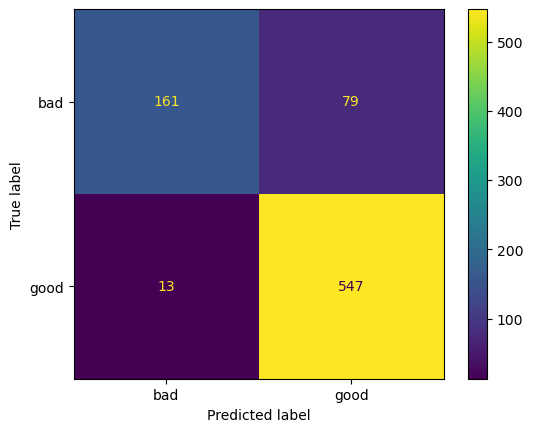

              precision    recall  f1-score   support

         bad       0.93      0.67      0.78       240
        good       0.87      0.98      0.92       560

    accuracy                           0.89       800
   macro avg       0.90      0.82      0.85       800
weighted avg       0.89      0.89      0.88       800


Métricas de avaliação de teste:
[[ 28  32]
 [ 12 128]]


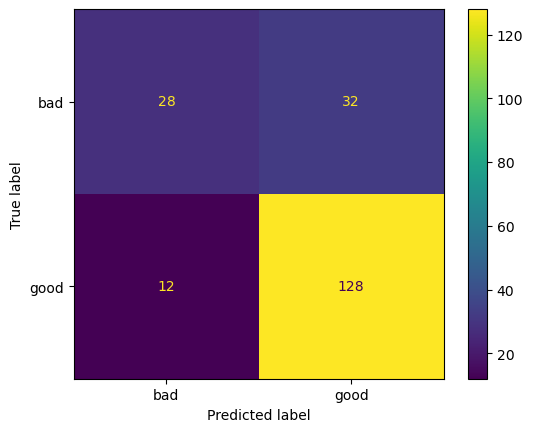

              precision    recall  f1-score   support

         bad       0.70      0.47      0.56        60
        good       0.80      0.91      0.85       140

    accuracy                           0.78       200
   macro avg       0.75      0.69      0.71       200
weighted avg       0.77      0.78      0.77       200



In [9]:
metricas_classificacao(pipe_gb)

Alterar alguns hiperâmetros:

learning_rate=0.1 -> learning_rate=1


Métricas de avaliação de treino:
[[240   0]
 [  0 560]]


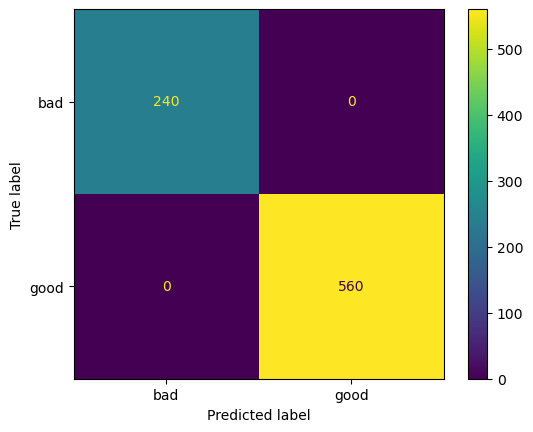

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Métricas de avaliação de teste:
[[ 34  26]
 [ 20 120]]


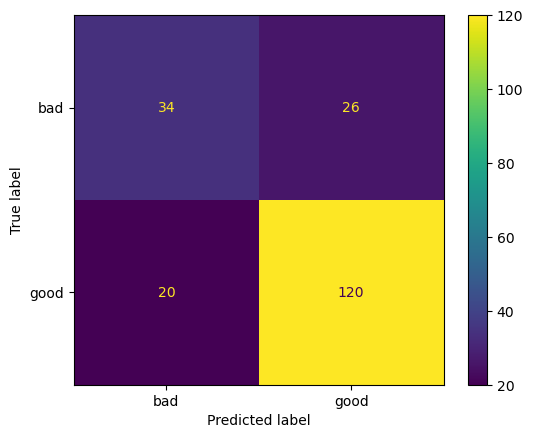

              precision    recall  f1-score   support

         bad       0.63      0.57      0.60        60
        good       0.82      0.86      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.76      0.77      0.77       200



In [10]:
X_train, y_train, X_test, y_test, pre_processador = pipe_pre_process_german(df, X, y)

pipe_gb = Pipeline([('pre_processador', pre_processador),
                     ('GradientBoosting', GradientBoostingClassifier(random_state=42,
                                                                     learning_rate=1))])

pipe_gb.fit(X_train, y_train)

metricas_classificacao(pipe_gb)

Alterar alguns hiperâmetros:

learning_rate=0.1 -> learning_rate=0.01


Métricas de avaliação de treino:
[[156  84]
 [ 14 546]]


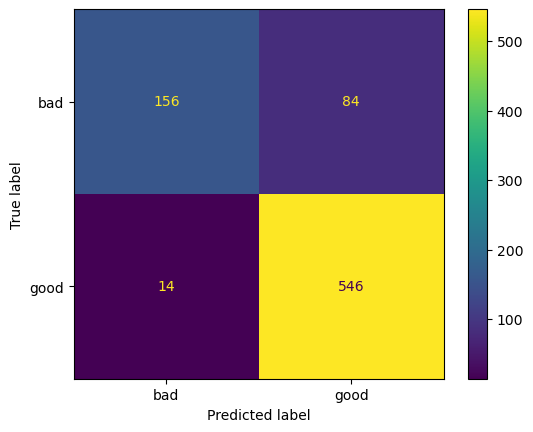

              precision    recall  f1-score   support

         bad       0.92      0.65      0.76       240
        good       0.87      0.97      0.92       560

    accuracy                           0.88       800
   macro avg       0.89      0.81      0.84       800
weighted avg       0.88      0.88      0.87       800


Métricas de avaliação de teste:
[[ 26  34]
 [ 13 127]]


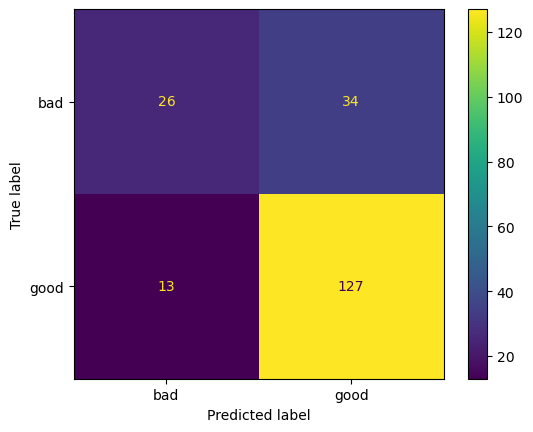

              precision    recall  f1-score   support

         bad       0.67      0.43      0.53        60
        good       0.79      0.91      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



In [12]:
X_train, y_train, X_test, y_test, pre_processador = pipe_pre_process_german(df, X, y)

pipe_gb = Pipeline([('pre_processador', pre_processador),
                     ('GradientBoosting', GradientBoostingClassifier(random_state=42,
                                                                     learning_rate=0.01,
                                                                     n_estimators=1000))])

pipe_gb.fit(X_train, y_train)

metricas_classificacao(pipe_gb)

## XGBoost

Chegamos ao nosso último método de ensemble, o XGBoost (e**X**treme **G**radient **Boost**ing).

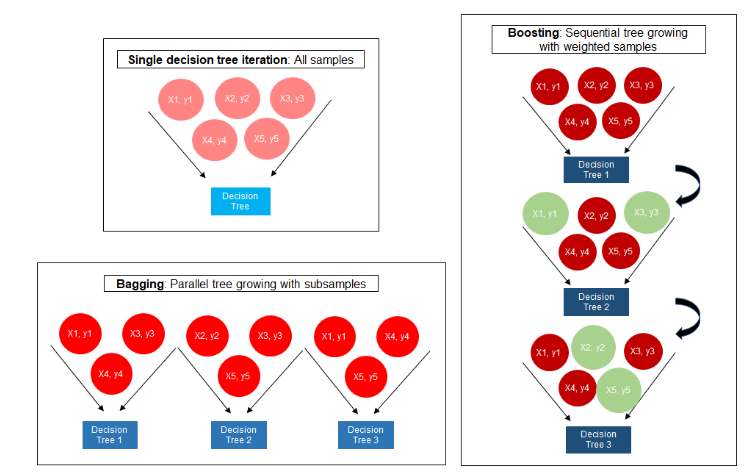

Este método nada mais é que um gradient boosting, mas com algumas importantes modificações que lhe conferem o título de "extreme"! Em particular, duas alterações merecem destaque:

- A adição de procedimentos de regularização (L1 e L2!), o que melhora consideravelmente sua capacidade de generalização;

- A utilização de derivadas de segunda ordem (Hessiano) para o procedimento de gradiente.

Para quem quiser se aventurar mais, sugiro algumas boas leituras:

- [Este](https://shirinsplayground.netlify.app/2018/11/ml_basics_gbm/), explica bem as particularidades do XGBoost, além de dar uma boa introdução ao gradient boosting (o código é em R, então pode ignorar essa parte hehe);

- [Este](https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb), introduz bem o método, enquanto enfativa suas particularidades, com alguns detalhes matemáticos;

- [Este](https://xgboost.readthedocs.io/en/latest/tutorials/model.html), da própria documentação da biblioteca, traz uma explicação legal, e com alguns detalhes matemáticos;

- [Este](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d), com uma discussão mais alto-nível (sem tantos detalhes) sobre o XGBoost e os motivos de seu sucesso.

Infelizmente, o sklearn não tem o XGBoost implementado :(

Mas, felizmente, existe uma biblioteca que o implementou, de maneira totalmente integrada ao sklearn!!

A biblioteca é a [XGBoost](https://xgboost.readthedocs.io/en/latest/).

Para instalar a biblioteca, o de sempre:

`!pip install xgboost`

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [13]:
!pip install xgboost

In [14]:
# biblioteca específica para o XGBoosting
from xgboost import XGBClassifier

In [15]:
df = pd.read_csv('../datasets/german_credit_data.csv', index_col=0)

X = df.select_dtypes(include=np.number)
y = df['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [16]:
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255], got [    0     1     2     3     6     7     8     9    10    11    12    14
    15    16    18    20    21    22    23    24    25    26    27    28
    29    30    31    32    33    34    35    36    37    38    39    40
    41    42    43    44    45    46    47    48    49    50    51    52
    53    54    55    58    60    61    63    65    66    67    75   250
   343   362   368   458   571   585   666   684   697   701   707   717
   727   759   760   766   795   836   846   884   886   915   918   931
   937   939  1007  1050  1055  1056  1082  1101  1103  1154  1168  1185
  1193  1203  1213  1216  1223  1237  1239  1240  1245  1249  1255  1258
  1262  1271  1278  1285  1295  1333  1337  1347  1360  1374  1381  1382
  1402  1413  1424  1442  1459  1469  1493  1495  1503  1514  1521  1530
  1534  1546  1554  1585  1602  1647  1655  1736  1743  1808  1817  1851
  1867  1881  1884  1887  1893  1901  1922  1928  1940  1943  1961  1987
  1995  2002  2012  2022  2039  2096  2118  2133  2136  2146  2171  2197
  2223  2279  2302  2320  2326  2327  2333  2353  2389  2397  2404  2439
  2445  2483  2511  2520  2538  2569  2606  2625  2629  2728  2746  2751
  2788  2872  2899  3001  3016  3017  3031  3077  3123  3149  3331  3368
  3535  3565  3573  3577  3612  3621  3643  3763  3835  3868  3872  3959
  3965  3973  4057  4280  4297  4308  4351  4380  4439  4454  4463  4473
  4605  4712  4716  5152  5842  5866  5951  5965  6148  6204  6224  6289
  6314  6468  7228  7511  7629  7678  7758  7980  8133  8471  8947  9283
  9566 11328 11760 12204]

In [21]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

xgb = XGBClassifier(random_state=42)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Métricas de avaliação de treino:
[[234   6]
 [  0 560]]


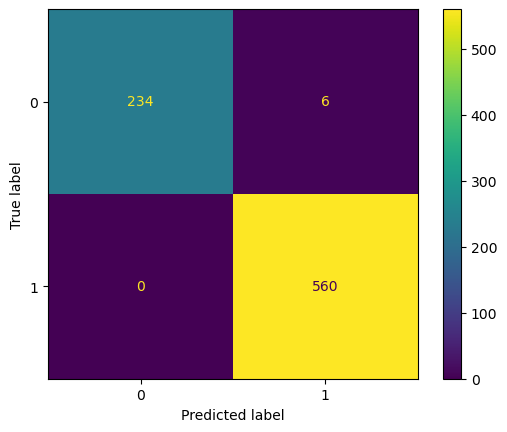

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       240
           1       0.99      1.00      0.99       560

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800


Métricas de avaliação de teste:
[[ 14  46]
 [ 33 107]]


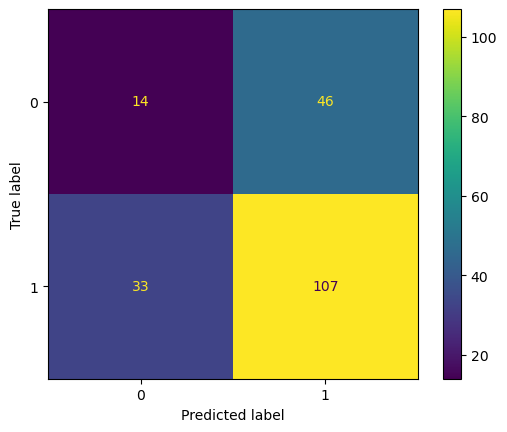

              precision    recall  f1-score   support

           0       0.30      0.23      0.26        60
           1       0.70      0.76      0.73       140

    accuracy                           0.60       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.58      0.60      0.59       200



In [22]:
metricas_classificacao(xgb)

# Feature importance

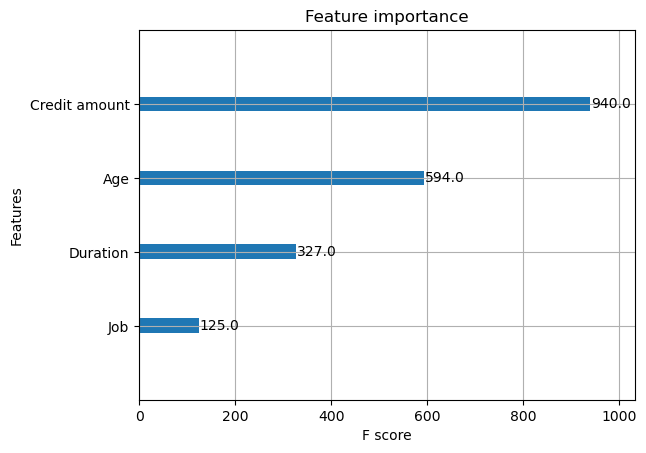

In [23]:
from xgboost import plot_importance

plot_importance(xgb);

Não precisa normalizar ou padronizar pois ele é baseado em árvores. As árvores não usam métodos de distância e sim separação dos dados de uma feature

In [24]:
x_importance = X[['Credit amount', 'Age', 'Duration']]

X_train, X_test, y_train, y_test = train_test_split(x_importance, y, test_size=0.2, stratify=y)

xgb = XGBClassifier(random_state=42)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Métricas de avaliação de treino:
[[219  21]
 [  2 558]]


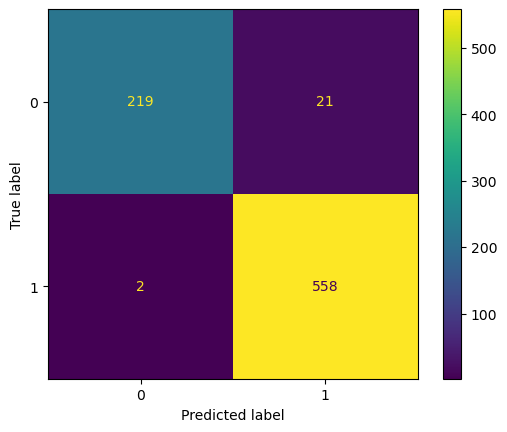

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       240
           1       0.96      1.00      0.98       560

    accuracy                           0.97       800
   macro avg       0.98      0.95      0.96       800
weighted avg       0.97      0.97      0.97       800


Métricas de avaliação de teste:
[[ 26  34]
 [ 32 108]]


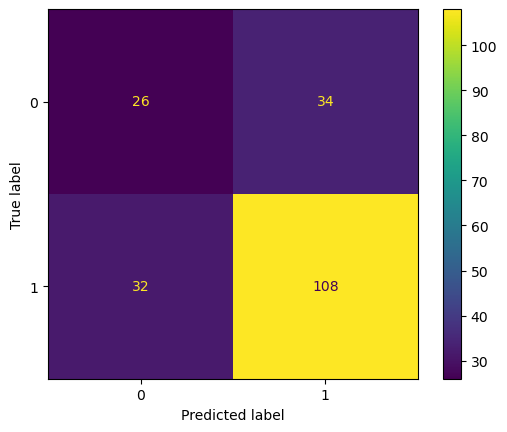

              precision    recall  f1-score   support

           0       0.45      0.43      0.44        60
           1       0.76      0.77      0.77       140

    accuracy                           0.67       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.67      0.67      0.67       200



In [25]:
metricas_classificacao(xgb)

____
____
____

## Bora praticar?
Admission_Predict.csv

Com os dados do arquivo Admission_Predict.csv realize uma classificação dos alunos que possuem chance maior que 0.8 de admissão e dos que possuem chance menor ou igual a 0.8. Treinar os modelos de boost aprendidos na aula de hoje.

____
____
____

## Mini tarefa

Usando o dataset de infarto (heart.csv), obtenha a acurácia de três modelos
- AdaBoost com 100 estimadores
- Gradient Boost com 120 estimadores e taxa de aprendizado de 0.001
- XGBoost com profundidade máxima de 6 e taxa de aprendizado de 0.2  
  
Utilize todas as variáveis presentes no dataset e divida em treino e teste, sendo 20% para teste, com random state igual a 42. Envie o valor encontrado no link do [forms](https://forms.gle/reLfqC8DBC2MBPXR8)

Sobre o dataset:  

- **Age** Idade do paciente  
- **Sex** Gênero do paciente  
- **exang** exercise induced angina (1 = yes; 0 = no)  
- **ca** number of major vessels (0-3)  
- **cp** Chest Pain type chest pain type  
Value 1: typical angina  
Value 2: atypical angina  
Value 3: non-anginal pain  
Value 4: asymptomatic  
- **trtbps** Pressão arterial em repouso (in mm Hg)  
- **chol** Colesterol  
- **fbs** glicemia > 120 mg/dl (1 = true; 0 = false)  
- **rest_ecg** resultados do eletrocardiograma em repouso  
Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **thalach** Máximo valor de batimentos registrados

- **target** 0= Chances menores de infarto 1= Maiores chances de infarto

**AdaBoost**

**Gradient Boost**

**XGBoost**

____
____
____